In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
from tqdm import tqdm
import math

os.environ['WANDB_SILENT'] = "true"
import wandb
import pandas as pd
from IPython.display import display
wandb.init(mode="offline")

/home/detour/anaconda3/envs/smai/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/detour/anaconda3/envs/smai/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because

/home/detour/anaconda3/envs/smai/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/detour/anaconda3/envs/smai/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because

In [2]:
def _watermark(username, ax):
    """Adds a watermark with the username to a plot's axes."""
    if username:
        ax.text(0.98, 0.98, username, ha='right', va='top', transform=ax.transAxes, 
                fontsize=10, color='gray', alpha=0.6)

def convert_to_binary_mask(img_array):
    """
    Converts the specific orange/purple RGB image to a 0-1 binary mask.
    Netherlands (orange) becomes 1, Belgium (purple) becomes 0.
    """
    return (img_array[:, :, 1] > img_array[:, :, 2]).astype(int)

In [3]:
class BorderDataset:
    """
    Dataset class for the Belgium-Netherlands border image[cite: 75].
    Handles loading, normalization, shuffling, and batching of pixel data.
    """
    def __init__(self, binary_mask):
        self.height, self.width = binary_mask.shape
        
        # Vectorized coordinate and label generation for efficiency
        xx, yy = np.meshgrid(np.arange(self.width), np.arange(self.height))
        self.coordinates = np.stack([xx.ravel(), yy.ravel()], axis=1).astype(np.float32)
        self.labels = binary_mask.ravel().reshape(-1, 1)

    def __len__(self):
        return self.coordinates.shape[0]

    def shuffle_data(self):
        """Shuffles the dataset's coordinates and labels in unison."""
        indices = np.random.permutation(len(self))
        self.coordinates = self.coordinates[indices]
        self.labels = self.labels[indices]

    def get_batch(self, start_idx, end_idx):
        """
        Gets a batch of samples and normalizes coordinates to the range [0, 1][cite: 77].
        """
        coords_batch = self.coordinates[start_idx:end_idx]
        labels_batch = self.labels[start_idx:end_idx]
        
        # Normalize coordinates
        norm_coords = coords_batch / np.array([self.width - 1, self.height - 1])
        return norm_coords, labels_batch

In [4]:
class Activation:
    """Base class for activation functions."""
    def forward(self, x):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

    def __str__(self):
        return self.__class__.__name__

class Identity(Activation):
    """Identity activation (no operation)."""
    def forward(self, x):
        return x
    
    def backward(self, grad_output):
        return grad_output

class ReLU(Activation):
    """ReLU activation function."""
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad_output):
        return grad_output * (self.input > 0)

class Tanh(Activation):
    """Tanh activation function."""
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (1 - self.output**2)

class Sigmoid(Activation):
    """Sigmoid activation function."""
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output
    
    def backward(self, grad_output):
        return grad_output * self.output * (1 - self.output)

In [5]:
class Linear:
    """A fully connected linear layer."""
    def __init__(self, input_dim, output_dim, activation=Identity()):
        if isinstance(activation, ReLU):
            limit = np.sqrt(6 / input_dim)
        else:
            limit = np.sqrt(6 / (input_dim + output_dim)) 
            
        self.weights = np.random.uniform(-limit, limit, (input_dim, output_dim))
        self.biases = np.zeros((1, output_dim))
        self.activation = activation
        
        self.input = None
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)

    def forward(self, x):
        """Performs the forward pass for the layer."""
        self.input = x
        pre_activation = x @ self.weights + self.biases
        return self.activation.forward(pre_activation)

    def backward(self, grad_output):
        """Performs the backward pass and accumulates gradients."""
        grad_pre_activation = self.activation.backward(grad_output)
        
        self.grad_weights += self.input.T @ grad_pre_activation
        self.grad_biases += np.sum(grad_pre_activation, axis=0, keepdims=True)
        
        return grad_pre_activation @ self.weights.T
    
    def get_params(self):
        """Returns the layer's parameters."""
        return {'weights': self.weights, 'biases': self.biases}

    def set_params(self, params):
        """Sets the layer's parameters from a dictionary."""
        self.weights = params['weights']
        self.biases = params['biases']

In [6]:
class Loss:
    """Base class for loss functions."""
    def forward(self, y_pred, y_true):
        raise NotImplementedError

    def backward(self, y_pred, y_true):
        raise NotImplementedError

class MSE(Loss):
    """Mean Squared Error loss."""
    def forward(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)
    
    def backward(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.shape[0]

class BCE(Loss):
    """Binary Cross Entropy loss."""
    def forward(self, y_pred, y_true):
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def backward(self, y_pred, y_true):
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        grad = (y_pred - y_true) / (y_pred * (1 - y_pred))
        return grad / y_true.shape[0]

In [7]:
class Model:
    """A neural network model composed of a list of layers."""
    def __init__(self, layers, loss_fn):
        self.layers = layers
        self.loss_fn = loss_fn

    def forward(self, x):
        """Sequentially executes the forward pass in each layer."""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        """Sequentially executes the backward pass in reverse order."""
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def train_step(self, x, y):
        """Performs a single training step: forward, loss, backward."""
        y_pred = self.forward(x)
        loss = self.loss_fn.forward(y_pred, y)
        initial_grad = self.loss_fn.backward(y_pred, y)
        self.backward(initial_grad)
        return loss

    def zero_grad(self):
        """Resets gradients in all layers to zero."""
        for layer in self.layers:
            layer.grad_weights.fill(0)
            layer.grad_biases.fill(0)

    def update(self, learning_rate):
        """Updates parameters in all layers."""
        for layer in self.layers:
            layer.weights -= learning_rate * layer.grad_weights
            layer.biases -= learning_rate * layer.grad_biases
            
    def predict(self, x):
        """Performs a forward pass to get a prediction."""
        return self.forward(x)

    def save_to(self, path):
        """Saves all model parameters to a .npz file."""
        params = {}
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'get_params'):
                for key, value in layer.get_params().items():
                    params[f'layer_{i}_{key}'] = value
        np.savez(path, **params)

    def load_from(self, path):
        """Loads model parameters, verifying architecture shape."""
        data = np.load(path)
        for i, layer in enumerate(self.layers):
            weights = data[f'layer_{i}_weights']
            biases = data[f'layer_{i}_biases']
            
            if weights.shape != layer.weights.shape or biases.shape != layer.biases.shape:
                raise ValueError(f"Shape mismatch in layer {i}.")
            layer.set_params({'weights': weights, 'biases': biases})

In [8]:
def train_model(
    model, 
    data,
    run_name,
    username,
    epochs, 
    batch_size, 
    learning_rate, 
    wandb_config,
    grad_accumulation_steps = 1,
    patience = 510,
    relative_loss_threshold = 0.01,
    RUNS_DIR = "runs"
    ):
    """
    Implements the main training loop with logging and early stopping.
    """
    run_folder = os.path.join(RUNS_DIR, f"{run_name}_{int(time.time())}")
    os.makedirs(run_folder, exist_ok=True)
    
    run = wandb.init(project="SMAI-A3-Border-Prediction", name=run_name, config=wandb_config)

    history = {'loss': [], 'samples_seen': []}
    samples_seen = 0
    loss_history_for_es = []
    
    epoch_iterator = tqdm(range(epochs), desc=f"Training '{run_name}'")
    
    is_dataset_object = isinstance(data, BorderDataset)

    for epoch in epoch_iterator:
        if is_dataset_object:
            data.shuffle_data()
            num_samples = len(data)
        else: 
            X, y = data
            num_samples = X.shape[0]
            indices = np.random.permutation(num_samples)
            X, y = X[indices], y[indices]

        num_batches = math.ceil(num_samples / batch_size)
        epoch_loss = 0
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            
            if is_dataset_object:
                x_batch, y_batch = data.get_batch(start_idx, end_idx)
            else:
                x_batch, y_batch = X[start_idx:end_idx], y[start_idx:end_idx]
            
            if x_batch.shape[0] == 0: continue
                
            batch_loss = model.train_step(x_batch, y_batch)
            epoch_loss += batch_loss * x_batch.shape[0]
            samples_seen += x_batch.shape[0]
            
            if (i + 1) % grad_accumulation_steps == 0 or (i + 1) == num_batches:
                effective_lr = learning_rate / grad_accumulation_steps
                model.update(effective_lr)
                model.zero_grad()

        avg_epoch_loss = epoch_loss / num_samples
        history['loss'].append(avg_epoch_loss)
        history['samples_seen'].append(samples_seen)
        loss_history_for_es.append(avg_epoch_loss)
        
        epoch_iterator.set_postfix(loss=f"{avg_epoch_loss:.6f}")
        wandb.log({'epoch': epoch + 1, 'loss': avg_epoch_loss, 'samples_seen': samples_seen})
        
        if len(loss_history_for_es) > patience:
            if loss_history_for_es[-1] >= (1 - relative_loss_threshold) * loss_history_for_es[-(patience + 1)]:
                print(f"\nEarly stopping triggered at epoch {epoch+1}.")
                break
                
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history['samples_seen'], history['loss'])
    ax.set_title(f'Training Loss vs. Samples Seen ({run_name})')
    ax.set_xlabel('Number of Samples Seen')
    ax.set_ylabel('Loss')
    ax.grid(True)
    _watermark(username, ax)
    
    plot_path = os.path.join(run_folder, "loss_plot.png")
    plt.savefig(plot_path)
    plt.close()

    model_path = os.path.join(run_folder, "final_model.npz")
    model.save_to(model_path)
    
    wandb.finish()
    return model, history, run_folder

In [9]:
USERNAME = "reddy.bathula" 

img = Image.open('/home/detour/Documents/SMAI/Assignments/assignment3/Datasets/Q1/border.png') 
img_array = np.array(img)


--- Visualizing Input Image and Generated Binary Mask ---


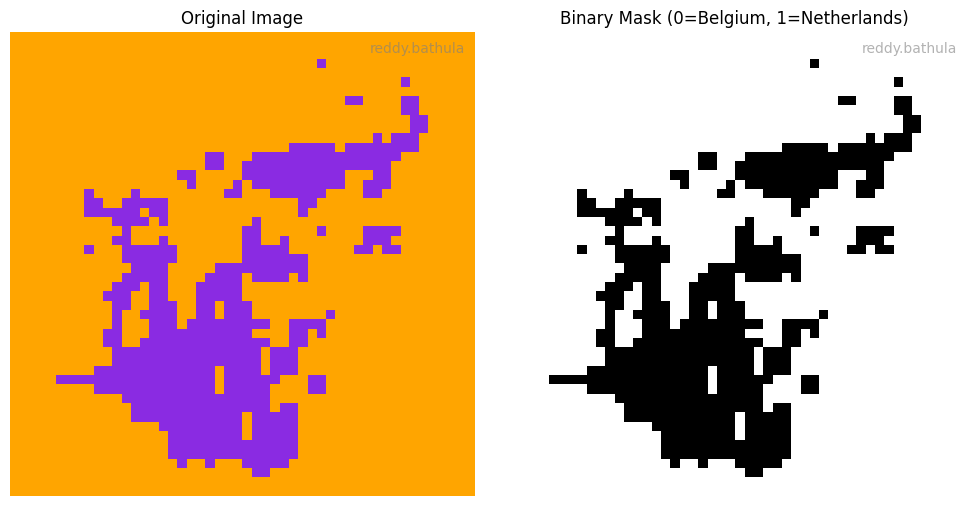

In [10]:
binary_mask = convert_to_binary_mask(img_array)
    
print("\n--- Visualizing Input Image and Generated Binary Mask ---")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_array)
axes[0].set_title("Original Image")
axes[0].axis('off')
_watermark(USERNAME, axes[0])

axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title("Binary Mask (0=Belgium, 1=Netherlands)")
axes[1].axis('off')
_watermark(USERNAME, axes[1])

plt.tight_layout()
plt.show()

In [11]:
class XORDataset:
    """A simple dataset class for the XOR problem."""
    def __init__(self):
        self.X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
        self.y = np.array([[0], [1], [1], [0]])

def run_xor_sanity_check(username):
    """
    Executes the XOR sanity check for various standard architectures.
    """
    xor_dataset = XORDataset()
    xor_data_tuple = (xor_dataset.X, xor_dataset.y) 

    activations_to_test = {"ReLU": ReLU, "Tanh": Tanh, "Sigmoid": Sigmoid}
    results = []

    for act_name, act_class in activations_to_test.items():
        layers = [
            Linear(2, 8, activation=act_class()),
            Linear(8, 1, activation=Sigmoid())
        ]
        model = Model(layers, loss_fn=BCE())
        run_name = f"XOR-Check-{act_name}"
        
        train_model(
            model=model,
            data=xor_data_tuple,
            run_name=run_name,
            username=username,
            epochs=3000,
            batch_size=4, 
            learning_rate=0.1,
            wandb_config={"task": "XOR-Check"},
            patience=3001
        )
        
        preds = (model.predict(xor_dataset.X) > 0.5).astype(int)
        accuracy = np.mean(preds == xor_dataset.y) * 100
        status = "PASSED" if accuracy == 100.0 else "FAILED"
        print(f"-> Activation: {act_name}, Final Accuracy: {accuracy:.0f}%, Status: {status}")
        results.append({"Activation": act_name, "Accuracy": f"{accuracy:.0f}%", "Status": status})

    print("\n--- XOR Sanity Check Summary ---")
    display(pd.DataFrame(results))
    print("\nXOR Check Complete.\n")


def compute_numerical_gradient(model, X, Y, layer, param_name, epsilon=1e-5):
    """
    Computes the numerical gradient for a single parameter array (weights or biases)
    using the central difference formula.
    """
    param = getattr(layer, param_name)
    numerical_grad = np.zeros_like(param)
    
    it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        original_value = param[ix]
        param[ix] = original_value + epsilon
        loss_plus = model.loss_fn.forward(model.predict(X), Y)
        param[ix] = original_value - epsilon
        loss_minus = model.loss_fn.forward(model.predict(X), Y)
        param[ix] = original_value
        numerical_grad[ix] = (loss_plus - loss_minus) / (2 * epsilon)
        it.iternext()
        
    return numerical_grad

def run_gradient_check():
    """
    Verifies that the gradients computed by backpropagation match
    a numerical approximation of the gradient.
    """
    X_check, Y_check = np.array([[0, 1]]), np.array([[1]])
    model = Model([Linear(2, 4, ReLU()), Linear(4, 1, Sigmoid())], BCE())
    model.zero_grad()
    _ = model.train_step(X_check, Y_check)
    
    all_passed = True
    for i, layer in enumerate(model.layers):
        for param_name in ['weights', 'biases']:
            backprop_grad = getattr(layer, f'grad_{param_name}')
            numerical_grad = compute_numerical_gradient(model, X_check, Y_check, layer, param_name)
            
            # Compare the two gradients using relative error
            numerator = np.linalg.norm(numerical_grad - backprop_grad)
            denominator = np.linalg.norm(numerical_grad + backprop_grad)
            relative_error = numerator / (denominator + 1e-8) # Add epsilon to avoid division by zero
            
            status = "PASSED" if relative_error < 1e-7 else "FAILED"
            if status == "FAILED": all_passed = False
            
            print(f"-> Layer {i}, Param: {param_name}, Rel. Error: {relative_error:.2e}, Status: {status}")

    if all_passed:
        print("\n Gradient Check Complete. Backpropagation implementation is correct.")
    else:
        print("\n Gradient Check Failed. Review your backward pass logic.")

run_xor_sanity_check(username=USERNAME)
run_gradient_check()

Training 'XOR-Check-ReLU': 100%|██████████| 3000/3000 [00:02<00:00, 1427.66it/s, loss=0.006032]


Training 'XOR-Check-ReLU': 100%|██████████| 3000/3000 [00:02<00:00, 1427.66it/s, loss=0.006032]


-> Activation: ReLU, Final Accuracy: 100%, Status: PASSED


Training 'XOR-Check-ReLU': 100%|██████████| 3000/3000 [00:02<00:00, 1427.66it/s, loss=0.006032]


-> Activation: ReLU, Final Accuracy: 100%, Status: PASSED


Training 'XOR-Check-Tanh': 100%|██████████| 3000/3000 [00:02<00:00, 1451.59it/s, loss=0.007814]



Training 'XOR-Check-ReLU': 100%|██████████| 3000/3000 [00:02<00:00, 1427.66it/s, loss=0.006032]


-> Activation: ReLU, Final Accuracy: 100%, Status: PASSED


Training 'XOR-Check-Tanh': 100%|██████████| 3000/3000 [00:02<00:00, 1451.59it/s, loss=0.007814]



-> Activation: Tanh, Final Accuracy: 100%, Status: PASSED


Training 'XOR-Check-ReLU': 100%|██████████| 3000/3000 [00:02<00:00, 1427.66it/s, loss=0.006032]


-> Activation: ReLU, Final Accuracy: 100%, Status: PASSED


Training 'XOR-Check-Tanh': 100%|██████████| 3000/3000 [00:02<00:00, 1451.59it/s, loss=0.007814]



-> Activation: Tanh, Final Accuracy: 100%, Status: PASSED


Training 'XOR-Check-Sigmoid': 100%|██████████| 3000/3000 [00:02<00:00, 1435.66it/s, loss=0.523863]



Training 'XOR-Check-ReLU': 100%|██████████| 3000/3000 [00:02<00:00, 1427.66it/s, loss=0.006032]


-> Activation: ReLU, Final Accuracy: 100%, Status: PASSED


Training 'XOR-Check-Tanh': 100%|██████████| 3000/3000 [00:02<00:00, 1451.59it/s, loss=0.007814]



-> Activation: Tanh, Final Accuracy: 100%, Status: PASSED


Training 'XOR-Check-Sigmoid': 100%|██████████| 3000/3000 [00:02<00:00, 1435.66it/s, loss=0.523863]



-> Activation: Sigmoid, Final Accuracy: 75%, Status: FAILED

--- XOR Sanity Check Summary ---


,Activation,Accuracy,Status
0,ReLU,100%,PASSED
1,Tanh,100%,PASSED
2,Sigmoid,75%,FAILED



XOR Check Complete.

-> Layer 0, Param: weights, Rel. Error: 1.47e-12, Status: PASSED
-> Layer 0, Param: biases, Rel. Error: 1.47e-12, Status: PASSED
-> Layer 1, Param: weights, Rel. Error: 7.26e-12, Status: PASSED
-> Layer 1, Param: biases, Rel. Error: 5.05e-12, Status: PASSED

 Gradient Check Complete. Backpropagation implementation is correct.


In [11]:
def test_single_architecture(depth, width, act_class, act_name, username):
    """Performs both tests for one architecture using the main train_model."""
    # Build the model architecture
    layers = [Linear(2, width, act_class())]
    for _ in range(depth - 2):
        layers.append(Linear(width, width, act_class()))
    layers.append(Linear(width, 1, Sigmoid()))
    
    xor_data = XORDataset()
    model_xor = Model(layers, BCE())
    

    trained_model, _, _ = train_model(
        model=model_xor,
        data=(xor_data.X, xor_data.y),
        run_name=f"XOR-D{depth}-W{width}-{act_name}",
        username=username,
        epochs=2000,
        batch_size=1,
        learning_rate=0.1,
        wandb_config={"task": "XOR-Comprehensive-Test"},
        patience=2001, 
        RUNS_DIR="runs/xor_sanity_checks"
    )
    
    preds = (trained_model.predict(xor_data.X) > 0.5).astype(int)
    accuracy = np.mean(preds == xor_data.y) * 100

    X_check, Y_check = np.array([[0, 1]]), np.array([[1]])
    model_grad = Model(layers, BCE()) 
    model_grad.zero_grad()
    model_grad.train_step(X_check, Y_check)
    
    is_passed = True
    for layer in model_grad.layers:
        for param in ['weights', 'biases']:
            backprop_grad = getattr(layer, f'grad_{param}')
            numerical_grad = compute_numerical_gradient(model_grad, X_check, Y_check, layer, param)
            rel_error = np.linalg.norm(numerical_grad - backprop_grad) / (np.linalg.norm(numerical_grad + backprop_grad) + 1e-8)
            if not (rel_error < 1e-5):
                is_passed = False; break
        if not is_passed: break
    
    return {
        "Depth": depth, "Width": width, "Activation": act_name,
        "XOR Accuracy (%)": f"{accuracy:.0f}", "Gradient Check": "PASSED" if is_passed else "FAILED"
    }

depths_to_test = [2, 4]
widths_to_test = [4, 8, 16]
activations_to_test = {"ReLU": ReLU, "Tanh": Tanh, "Sigmoid": Sigmoid, "Identity": Identity}

all_results = []

# Create an iterator for the progress bar
total_combinations = len(depths_to_test) * len(widths_to_test) * len(activations_to_test)
pbar = tqdm(total=total_combinations, desc="Testing Architectures")

# Loop through all combinations
for depth in depths_to_test:
    for width in widths_to_test:
        for act_name, act_class in activations_to_test.items():
            result = test_single_architecture(depth, width, act_class, act_name,username=USERNAME)
            all_results.append(result)
            pbar.update(1)
            
pbar.close()

# Display the final results table
results_df = pd.DataFrame(all_results)
print("\n\n--- Comprehensive Architecture Test Summary ---")
display(results_df)

Testing Architectures: 100%|██████████| 24/24 [04:52<00:00, 12.17s/it]



--- Comprehensive Architecture Test Summary ---


,Depth,Width,Activation,XOR Accuracy (%),Gradient Check
0,2,4,ReLU,50,PASSED
1,2,4,Tanh,100,PASSED
2,2,4,Sigmoid,75,PASSED
3,2,4,Identity,50,PASSED
4,2,8,ReLU,100,PASSED
5,2,8,Tanh,100,PASSED
6,2,8,Sigmoid,75,PASSED
7,2,8,Identity,50,PASSED
8,2,16,ReLU,100,PASSED
9,2,16,Tanh,100,PASSED


In [11]:
def manual_train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Manually splits a dataset into training and testing sets.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    num_samples = len(X)
    shuffled_indices = np.random.permutation(num_samples)
    
    split_index = int(num_samples * (1 - test_size))
    
    train_indices = shuffled_indices[:split_index]
    test_indices = shuffled_indices[split_index:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

def plot_map_results(model, all_coords, all_labels, binary_mask_shape, username, save_path):
    """
    Generates and saves the 3-panel plot for the map prediction task.
    """
    height, width = binary_mask_shape
    
    # Get model's predictions for the entire map
    y_pred_probs = model.predict(all_coords)
    y_pred_binary = (y_pred_probs > 0.5).astype(int)

    # Reshape flat arrays back into images for plotting
    ground_truth_map = all_labels.reshape(height, width)
    prediction_map = y_pred_binary.reshape(height, width)
    error_map_img = (ground_truth_map - prediction_map)**2
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Map Prediction Analysis for {os.path.basename(save_path)}", fontsize=16)

    # Panel 1: Ground Truth
    axes[0].imshow(ground_truth_map, cmap='coolwarm', origin='upper')
    axes[0].set_title("Ground Truth")
    axes[0].axis('off')
    _watermark(username, axes[0])

    # Panel 2: Model's Prediction
    axes[1].imshow(prediction_map, cmap='coolwarm', origin='upper')
    axes[1].set_title("Model's Prediction")
    axes[1].axis('off')
    _watermark(username, axes[1])

    # Panel 3: Error Map (Misclassified pixels are non-black)
    axes[2].imshow(ground_truth_map, cmap='gray', origin='upper', alpha=0.7)
    axes[2].imshow(error_map_img, cmap='hot', alpha=0.5, origin='upper')
    axes[2].set_title("Error Map (Misclassified)")
    axes[2].axis('off')
    _watermark(username, axes[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path)
    plt.close()


Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---


Training 'Map-Tanh-D8-W16':  21%|██▏       | 851/4000 [00:05<00:19, 164.39it/s, loss=0.307472]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---


Training 'Map-Tanh-D8-W16':  21%|██▏       | 851/4000 [00:05<00:19, 164.39it/s, loss=0.307472]



Early stopping triggered at epoch 852.
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---


Training 'Map-Tanh-D8-W16':  21%|██▏       | 851/4000 [00:05<00:19, 164.39it/s, loss=0.307472]



Early stopping triggered at epoch 852.
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---


Training 'Map-Tanh-D8-W32':  20%|█▉        | 791/4000 [00:08<00:34, 91.71it/s, loss=0.307146]



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---


Training 'Map-Tanh-D8-W16':  21%|██▏       | 851/4000 [00:05<00:19, 164.39it/s, loss=0.307472]



Early stopping triggered at epoch 852.
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---


Training 'Map-Tanh-D8-W32':  20%|█▉        | 791/4000 [00:08<00:34, 91.71it/s, loss=0.307146]



Early stopping triggered at epoch 792.
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---


Training 'Map-Tanh-D8-W16':  21%|██▏       | 851/4000 [00:05<00:19, 164.39it/s, loss=0.307472]



Early stopping triggered at epoch 852.
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---


Training 'Map-Tanh-D8-W32':  20%|█▉        | 791/4000 [00:08<00:34, 91.71it/s, loss=0.307146]



Early stopping triggered at epoch 792.
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT


,Activation,Depth,Width,Loss,Accuracy
0,ReLU,2,4,0.4831,81.20%
1,ReLU,2,8,0.2730,88.60%
2,ReLU,2,16,0.2547,87.20%
3,ReLU,2,32,0.2994,84.80%
4,ReLU,4,4,0.3485,85.40%
5,ReLU,4,8,0.2663,89.00%
6,ReLU,4,16,0.2466,85.80%
7,ReLU,4,32,0.2502,88.60%
8,ReLU,6,4,0.4050,81.20%
9,ReLU,6,8,0.2647,86.60%



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---


Training 'Map-Tanh-D8-W16':  21%|██▏       | 851/4000 [00:05<00:19, 164.39it/s, loss=0.307472]



Early stopping triggered at epoch 852.
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---


Training 'Map-Tanh-D8-W32':  20%|█▉        | 791/4000 [00:08<00:34, 91.71it/s, loss=0.307146]



Early stopping triggered at epoch 792.
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT


,Activation,Depth,Width,Loss,Accuracy
0,ReLU,2,4,0.4831,81.20%
1,ReLU,2,8,0.2730,88.60%
2,ReLU,2,16,0.2547,87.20%
3,ReLU,2,32,0.2994,84.80%
4,ReLU,4,4,0.3485,85.40%
5,ReLU,4,8,0.2663,89.00%
6,ReLU,4,16,0.2466,85.80%
7,ReLU,4,32,0.2502,88.60%
8,ReLU,6,4,0.4050,81.20%
9,ReLU,6,8,0.2647,86.60%



Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---


Training 'Map-Tanh-D8-W16':  21%|██▏       | 851/4000 [00:05<00:19, 164.39it/s, loss=0.307472]



Early stopping triggered at epoch 852.
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---


Training 'Map-Tanh-D8-W32':  20%|█▉        | 791/4000 [00:08<00:34, 91.71it/s, loss=0.307146]



Early stopping triggered at epoch 792.
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT


,Activation,Depth,Width,Loss,Accuracy
0,ReLU,2,4,0.4831,81.20%
1,ReLU,2,8,0.2730,88.60%
2,ReLU,2,16,0.2547,87.20%
3,ReLU,2,32,0.2994,84.80%
4,ReLU,4,4,0.3485,85.40%
5,ReLU,4,8,0.2663,89.00%
6,ReLU,4,16,0.2466,85.80%
7,ReLU,4,32,0.2502,88.60%
8,ReLU,6,4,0.4050,81.20%
9,ReLU,6,8,0.2647,86.60%


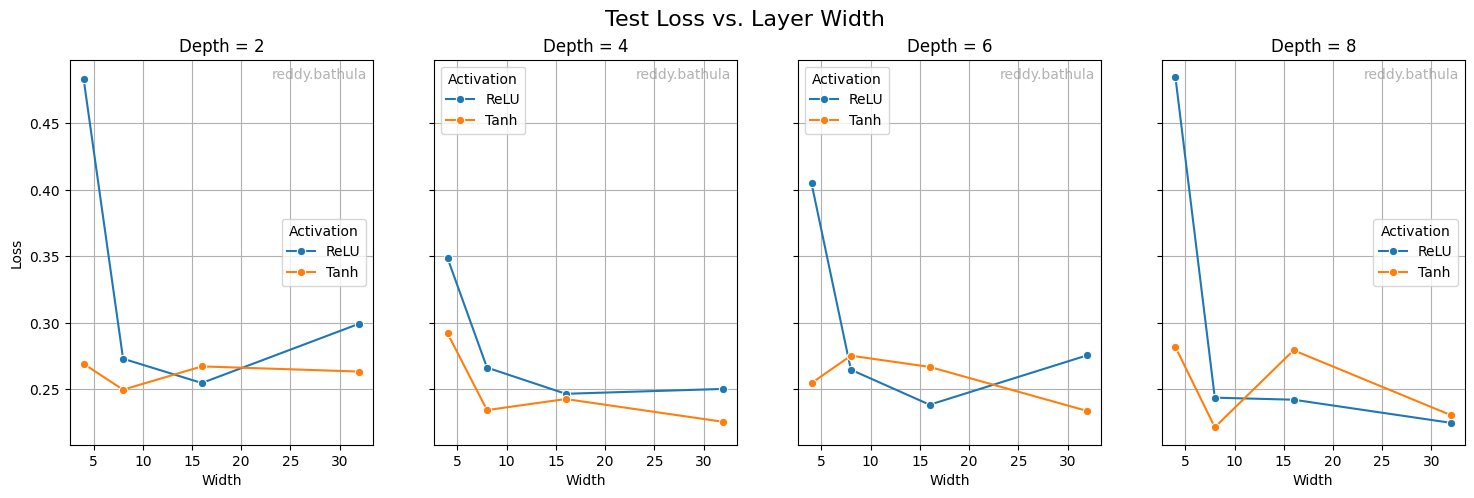


Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---


Training 'Map-Tanh-D8-W16':  21%|██▏       | 851/4000 [00:05<00:19, 164.39it/s, loss=0.307472]



Early stopping triggered at epoch 852.
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---


Training 'Map-Tanh-D8-W32':  20%|█▉        | 791/4000 [00:08<00:34, 91.71it/s, loss=0.307146]



Early stopping triggered at epoch 792.
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT


,Activation,Depth,Width,Loss,Accuracy
0,ReLU,2,4,0.4831,81.20%
1,ReLU,2,8,0.2730,88.60%
2,ReLU,2,16,0.2547,87.20%
3,ReLU,2,32,0.2994,84.80%
4,ReLU,4,4,0.3485,85.40%
5,ReLU,4,8,0.2663,89.00%
6,ReLU,4,16,0.2466,85.80%
7,ReLU,4,32,0.2502,88.60%
8,ReLU,6,4,0.4050,81.20%
9,ReLU,6,8,0.2647,86.60%


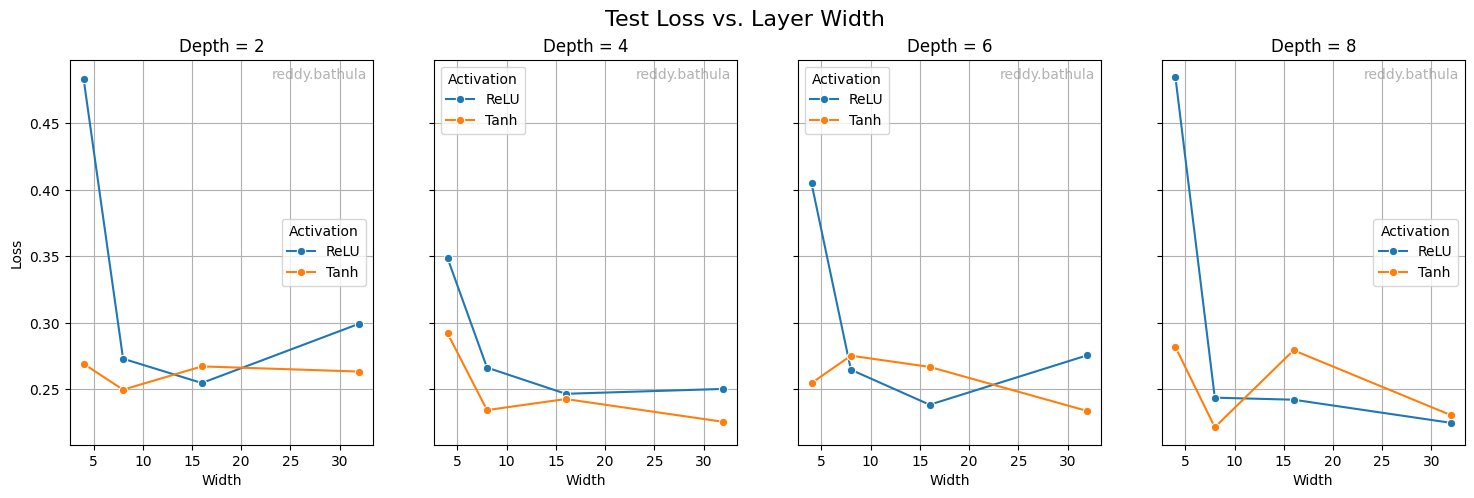


Executing 1.4: Map Prediction & Analysis

--- Training: Map-ReLU-D2-W4 ---


Training 'Map-ReLU-D2-W4':  15%|█▍        | 582/4000 [00:00<00:04, 781.99it/s, loss=0.497684]




Early stopping triggered at epoch 583.
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---
-> Test Loss: 0.4831, Test Accuracy: 81.20%

--- Training: Map-ReLU-D2-W8 ---


Training 'Map-ReLU-D2-W8':  28%|██▊       | 1115/4000 [00:01<00:03, 724.52it/s, loss=0.316491]




Early stopping triggered at epoch 1116.
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---
-> Test Loss: 0.2730, Test Accuracy: 88.60%

--- Training: Map-ReLU-D2-W16 ---


Training 'Map-ReLU-D2-W16':  31%|███▏      | 1254/4000 [00:01<00:04, 660.49it/s, loss=0.274463]



Early stopping triggered at epoch 1255.
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---
-> Test Loss: 0.2547, Test Accuracy: 87.20%

--- Training: Map-ReLU-D2-W32 ---


Training 'Map-ReLU-D2-W32':  19%|█▉        | 778/4000 [00:01<00:06, 535.31it/s, loss=0.343640]



Early stopping triggered at epoch 779.
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---
-> Test Loss: 0.2994, Test Accuracy: 84.80%

--- Training: Map-ReLU-D4-W4 ---


Training 'Map-ReLU-D4-W4':  24%|██▍       | 967/4000 [00:01<00:04, 626.68it/s, loss=0.394021]



Early stopping triggered at epoch 968.
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---
-> Test Loss: 0.3485, Test Accuracy: 85.40%

--- Training: Map-ReLU-D4-W8 ---


Training 'Map-ReLU-D4-W8':  19%|█▉        | 768/4000 [00:01<00:06, 535.17it/s, loss=0.345930]



Early stopping triggered at epoch 769.
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---
-> Test Loss: 0.2663, Test Accuracy: 89.00%

--- Training: Map-ReLU-D4-W16 ---


Training 'Map-ReLU-D4-W16':  23%|██▎       | 924/4000 [00:01<00:06, 467.41it/s, loss=0.250251]



Early stopping triggered at epoch 925.
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---
-> Test Loss: 0.2466, Test Accuracy: 85.80%

--- Training: Map-ReLU-D4-W32 ---


Training 'Map-ReLU-D4-W32':  19%|█▉        | 752/4000 [00:02<00:10, 315.07it/s, loss=0.343098]




Early stopping triggered at epoch 753.
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---
-> Test Loss: 0.2502, Test Accuracy: 88.60%

--- Training: Map-ReLU-D6-W4 ---


Training 'Map-ReLU-D6-W4':  21%|██        | 843/4000 [00:01<00:05, 550.19it/s, loss=0.434409]



Early stopping triggered at epoch 844.
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---
-> Test Loss: 0.4050, Test Accuracy: 81.20%

--- Training: Map-ReLU-D6-W8 ---


Training 'Map-ReLU-D6-W8':  19%|█▉        | 754/4000 [00:01<00:06, 478.78it/s, loss=0.337991]



Early stopping triggered at epoch 755.
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---
-> Test Loss: 0.2647, Test Accuracy: 86.60%

--- Training: Map-ReLU-D6-W16 ---


Training 'Map-ReLU-D6-W16':  18%|█▊        | 712/4000 [00:01<00:08, 371.91it/s, loss=0.273760]



Early stopping triggered at epoch 713.
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---
-> Test Loss: 0.2383, Test Accuracy: 88.40%

--- Training: Map-ReLU-D6-W32 ---


Training 'Map-ReLU-D6-W32':  19%|█▉        | 763/4000 [00:03<00:14, 226.48it/s, loss=0.250382]




Early stopping triggered at epoch 764.
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---
-> Test Loss: 0.2755, Test Accuracy: 88.00%

--- Training: Map-ReLU-D8-W4 ---


Training 'Map-ReLU-D8-W4':  13%|█▎        | 532/4000 [00:01<00:07, 482.76it/s, loss=0.513994]




Early stopping triggered at epoch 533.
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---
-> Test Loss: 0.4848, Test Accuracy: 81.20%

--- Training: Map-ReLU-D8-W8 ---


Training 'Map-ReLU-D8-W8':  23%|██▎       | 921/4000 [00:02<00:07, 411.96it/s, loss=0.292733]




Early stopping triggered at epoch 922.
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---
-> Test Loss: 0.2437, Test Accuracy: 89.60%

--- Training: Map-ReLU-D8-W16 ---


Training 'Map-ReLU-D8-W16':  17%|█▋        | 676/4000 [00:02<00:11, 296.25it/s, loss=0.294487]



Early stopping triggered at epoch 677.
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---
-> Test Loss: 0.2421, Test Accuracy: 89.20%

--- Training: Map-ReLU-D8-W32 ---


Training 'Map-ReLU-D8-W32':  16%|█▌        | 628/4000 [00:03<00:18, 185.96it/s, loss=0.283517]



Early stopping triggered at epoch 629.
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---
-> Test Loss: 0.2247, Test Accuracy: 90.40%

--- Training: Map-Tanh-D2-W4 ---


Training 'Map-Tanh-D2-W4':  75%|███████▍  | 2981/4000 [00:04<00:01, 688.87it/s, loss=0.272393]



Early stopping triggered at epoch 2982.
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---
-> Test Loss: 0.2691, Test Accuracy: 87.40%

--- Training: Map-Tanh-D2-W8 ---


Training 'Map-Tanh-D2-W8':  92%|█████████▎| 3700/4000 [00:06<00:00, 577.01it/s, loss=0.253448]



Early stopping triggered at epoch 3701.
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---
-> Test Loss: 0.2497, Test Accuracy: 88.20%

--- Training: Map-Tanh-D2-W16 ---


Training 'Map-Tanh-D2-W16':  47%|████▋     | 1898/4000 [00:04<00:05, 416.61it/s, loss=0.295617]



Early stopping triggered at epoch 1899.
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---
-> Test Loss: 0.2672, Test Accuracy: 87.80%

--- Training: Map-Tanh-D2-W32 ---


Training 'Map-Tanh-D2-W32':  38%|███▊      | 1530/4000 [00:05<00:08, 284.01it/s, loss=0.302022]



Early stopping triggered at epoch 1531.
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---
-> Test Loss: 0.2633, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W4 ---


Training 'Map-Tanh-D4-W4':  32%|███▏      | 1299/4000 [00:02<00:05, 490.53it/s, loss=0.316349]



Early stopping triggered at epoch 1300.
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---
-> Test Loss: 0.2920, Test Accuracy: 87.00%

--- Training: Map-Tanh-D4-W8 ---


Training 'Map-Tanh-D4-W8':  48%|████▊     | 1928/4000 [00:04<00:05, 392.31it/s, loss=0.237678]




Early stopping triggered at epoch 1929.
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---
-> Test Loss: 0.2343, Test Accuracy: 89.20%

--- Training: Map-Tanh-D4-W16 ---


Training 'Map-Tanh-D4-W16':  41%|████      | 1625/4000 [00:06<00:08, 268.56it/s, loss=0.254085]



Early stopping triggered at epoch 1626.
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---
-> Test Loss: 0.2426, Test Accuracy: 88.40%

--- Training: Map-Tanh-D4-W32 ---


Training 'Map-Tanh-D4-W32':  40%|████      | 1608/4000 [00:09<00:14, 166.32it/s, loss=0.255577]



Early stopping triggered at epoch 1609.
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---
-> Test Loss: 0.2255, Test Accuracy: 89.80%

--- Training: Map-Tanh-D6-W4 ---


Training 'Map-Tanh-D6-W4':  21%|██▏       | 852/4000 [00:01<00:07, 431.57it/s, loss=0.306852]



Early stopping triggered at epoch 853.
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---
-> Test Loss: 0.2546, Test Accuracy: 87.60%

--- Training: Map-Tanh-D6-W8 ---


Training 'Map-Tanh-D6-W8':  26%|██▋       | 1057/4000 [00:03<00:09, 310.76it/s, loss=0.285299]



Early stopping triggered at epoch 1058.
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---
-> Test Loss: 0.2753, Test Accuracy: 85.60%

--- Training: Map-Tanh-D6-W16 ---


Training 'Map-Tanh-D6-W16':  24%|██▍       | 959/4000 [00:04<00:14, 210.53it/s, loss=0.275377]



Early stopping triggered at epoch 960.
-> Test Loss: 0.2668, Test Accuracy: 88.60%
-> Test Loss: 0.2668, Test Accuracy: 88.60%

--- Training: Map-Tanh-D6-W32 ---

--- Training: Map-Tanh-D6-W32 ---


Training 'Map-Tanh-D6-W32':  23%|██▎       | 934/4000 [00:07<00:25, 120.53it/s, loss=0.287721]




Early stopping triggered at epoch 935.
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---
-> Test Loss: 0.2336, Test Accuracy: 90.20%

--- Training: Map-Tanh-D8-W4 ---


Training 'Map-Tanh-D8-W4':  23%|██▎       | 933/4000 [00:02<00:08, 347.36it/s, loss=0.297752]



Early stopping triggered at epoch 934.
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---
-> Test Loss: 0.2818, Test Accuracy: 88.00%

--- Training: Map-Tanh-D8-W8 ---


Training 'Map-Tanh-D8-W8':  23%|██▎       | 917/4000 [00:03<00:12, 245.26it/s, loss=0.303089]



Early stopping triggered at epoch 918.
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---
-> Test Loss: 0.2214, Test Accuracy: 90.40%

--- Training: Map-Tanh-D8-W16 ---


Training 'Map-Tanh-D8-W16':  21%|██▏       | 851/4000 [00:05<00:19, 164.39it/s, loss=0.307472]



Early stopping triggered at epoch 852.
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---
-> Test Loss: 0.2793, Test Accuracy: 86.20%

--- Training: Map-Tanh-D8-W32 ---


Training 'Map-Tanh-D8-W32':  20%|█▉        | 791/4000 [00:08<00:34, 91.71it/s, loss=0.307146]



Early stopping triggered at epoch 792.
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT
-> Test Loss: 0.2304, Test Accuracy: 91.20%


               EXPERIMENT ANALYSIS REPORT


,Activation,Depth,Width,Loss,Accuracy
0,ReLU,2,4,0.4831,81.20%
1,ReLU,2,8,0.2730,88.60%
2,ReLU,2,16,0.2547,87.20%
3,ReLU,2,32,0.2994,84.80%
4,ReLU,4,4,0.3485,85.40%
5,ReLU,4,8,0.2663,89.00%
6,ReLU,4,16,0.2466,85.80%
7,ReLU,4,32,0.2502,88.60%
8,ReLU,6,4,0.4050,81.20%
9,ReLU,6,8,0.2647,86.60%


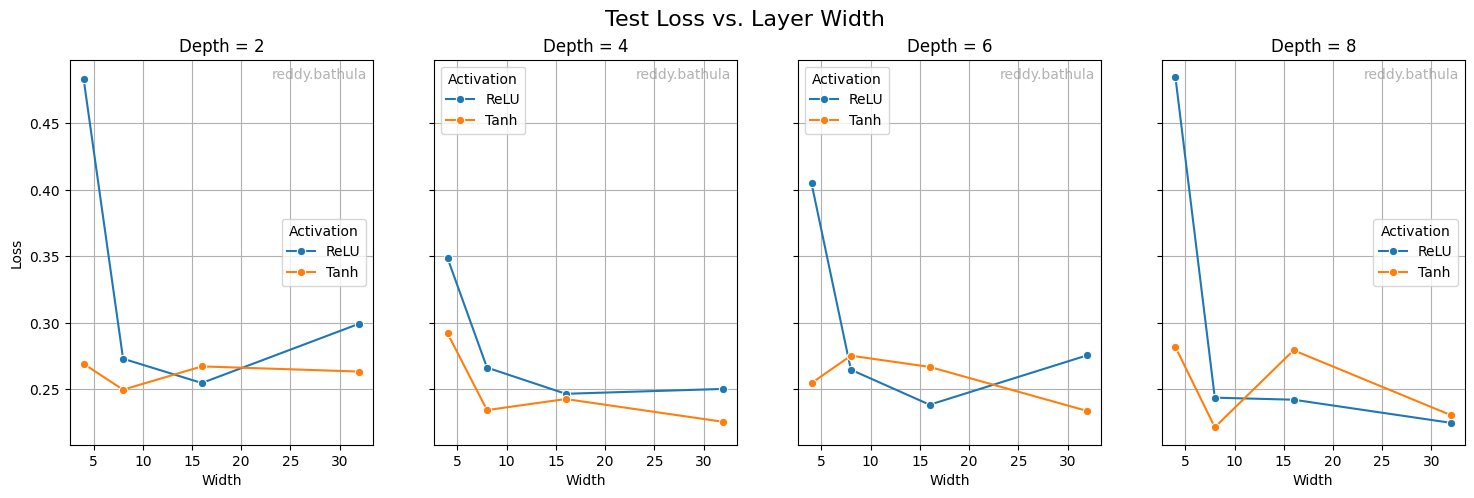

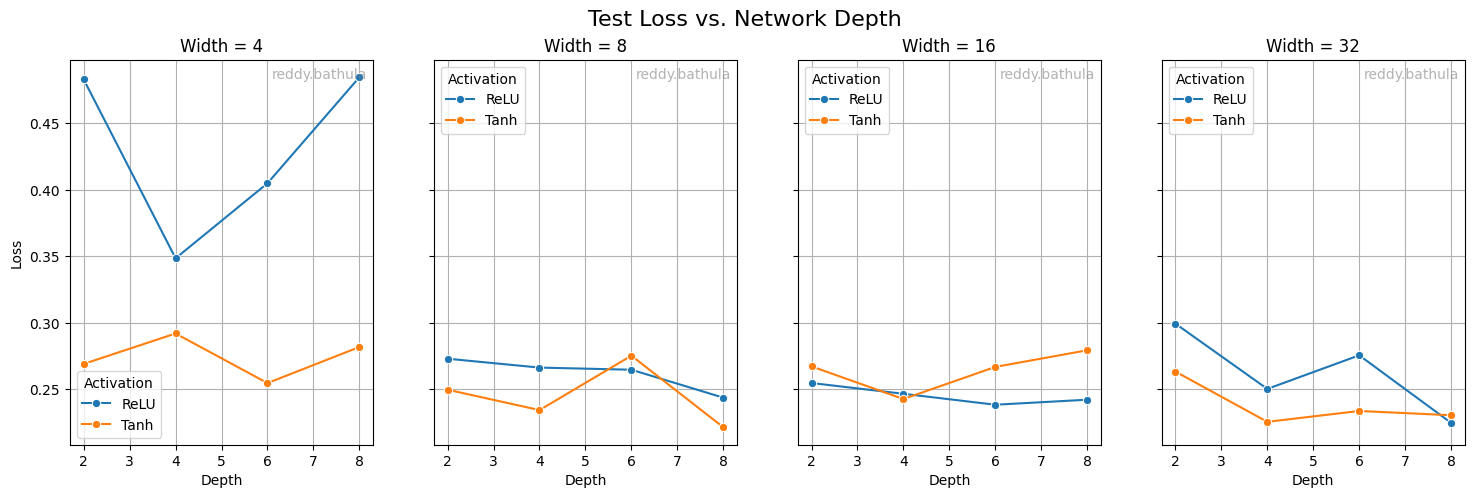

In [13]:
import seaborn as sns
from IPython.display import HTML
print("\n" + "="*50)
print("Executing 1.4: Map Prediction & Analysis")
print("="*50)

border_dataset = BorderDataset(binary_mask)
# 1. Prepare Data
all_coords_norm = border_dataset.coordinates / np.array([border_dataset.width - 1, border_dataset.height - 1])
X_train, X_test, y_train, y_test = manual_train_test_split(
    all_coords_norm, border_dataset.labels, test_size=0.2, random_state=42
)

# 2. Define Experiment Configurations
activations_to_test = {"ReLU": ReLU, "Tanh": Tanh}
depths = [2, 4, 6 ,8]
widths = [4, 8, 16, 32]

base_config = {
    "learning_rate": 0.1,
    "epochs": 4000,
    "batch_size": 512
}

results = []
RUNS_DIR = "runs/map_analysis"
os.makedirs(RUNS_DIR, exist_ok=True)

for act_name, act_class in activations_to_test.items():
    for depth in depths:
        for width in widths:
            run_name = f"Map-{act_name}-D{depth}-W{width}"
            print(f"\n--- Training: {run_name} ---")
            
            layers = [Linear(2, width, act_class())]
            for _ in range(depth - 1):
                layers.append(Linear(width, width, act_class()))
            layers.append(Linear(width, 1, Sigmoid()))
            model = Model(layers, loss_fn=BCE())
            
            wandb_config_dict = {
                "activation": act_name, 
                "depth": depth, 
                "width": width,
                **base_config
            }
            
            trained_model, _, _ = train_model(
                model=model, data=(X_train, y_train), run_name=run_name, 
                username=USERNAME, 
                epochs=base_config["epochs"],
                batch_size=base_config["batch_size"],
                learning_rate=base_config["learning_rate"],
                wandb_config=wandb_config_dict,
                RUNS_DIR=RUNS_DIR
            )
            
            test_preds = trained_model.predict(X_test)
            final_loss = BCE().forward(test_preds, y_test)
            final_acc = np.mean((test_preds > 0.5).astype(int) == y_test) * 100
            
            print(f"-> Test Loss: {final_loss:.4f}, Test Accuracy: {final_acc:.2f}%")
            
            plot_path = os.path.join(RUNS_DIR, f"{run_name}_maps.png")
            plot_map_results(trained_model, all_coords_norm, border_dataset.labels, 
                             (border_dataset.height, border_dataset.width), USERNAME, plot_path)
            
            results.append({
                "Activation": act_name, "Depth": depth, "Width": width,
                "Loss": final_loss, "Accuracy": final_acc
            })

results_df = pd.DataFrame(results)
print("\n\n" + "="*60)
print(" " * 15 + "EXPERIMENT ANALYSIS REPORT")
print("="*60)
display(HTML("<h3>Overall Results Summary</h3>"))
display(results_df.style.format({'Loss': '{:.4f}', 'Accuracy': '{:.2f}%'}))

display(HTML("<h3>Analysis: Performance vs. Width (for fixed Depth)</h3>"))
fig, axes = plt.subplots(1, len(depths), figsize=(18, 5), sharey=True)
fig.suptitle('Test Loss vs. Layer Width', fontsize=16)
for i, depth in enumerate(depths):
    df_subset = results_df[results_df['Depth'] == depth]
    sns.lineplot(data=df_subset, x='Width', y='Loss', hue='Activation', marker='o', ax=axes[i])
    axes[i].set_title(f'Depth = {depth}'); axes[i].grid(True); _watermark(USERNAME, axes[i])
plt.show()

display(HTML("<h3>Analysis: Performance vs. Depth (for fixed Width)</h3>"))
fig, axes = plt.subplots(1, len(widths), figsize=(18, 5), sharey=True)
fig.suptitle('Test Loss vs. Network Depth', fontsize=16)
for i, width in enumerate(widths):
    df_subset = results_df[results_df['Width'] == width]
    sns.lineplot(data=df_subset, x='Depth', y='Loss', hue='Activation', marker='o', ax=axes[i])
    axes[i].set_title(f'Width = {width}'); axes[i].grid(True); _watermark(USERNAME, axes[i])
plt.show()

In [14]:
depth = 2
width = 16
activation = ReLU()
act_name = "ReLU"

# Parameter configurations to test
optim_configs = [
    {'lr': 0.02,  'batch_size': 128, 'grad_accum': 1},
    {'lr': 0.1,   'batch_size': 128, 'grad_accum': 1},
    {'lr': 0.05,  'batch_size': 128, 'grad_accum': 1},
    {'lr': 0.01,  'batch_size': 128, 'grad_accum': 1},
    {'lr': 0.01,  'batch_size': 32,  'grad_accum': 1},
    {'lr': 0.01,  'batch_size': 64,  'grad_accum': 1},
    {'lr': 0.01,  'batch_size': 32,  'grad_accum': 2},
    {'lr': 0.01,  'batch_size': 32,  'grad_accum': 4},
]

opt_results = []

for cfg in optim_configs:
    run_name = f"OptTest-LR{cfg['lr']}-BS{cfg['batch_size']}-GA{cfg['grad_accum']}"
    print(f"\n--- Training: {run_name} ---")

    # Build model
    layers = [Linear(2, width, activation)]
    for _ in range(depth - 1):
        layers.append(Linear(width, width, activation))
    layers.append(Linear(width, 1, Sigmoid()))
    model = Model(layers, loss_fn=BCE())

    # WandB config
    wandb_config_dict = {
        "activation": act_name,
        "depth": depth,
        "width": width,
        "learning_rate": cfg["lr"],
        "batch_size": cfg["batch_size"],
        "grad_accumulation": cfg["grad_accum"]
    }

    # Train model
    trained_model, _, _ = train_model(
        model=model,
        data=(X_train, y_train),
        run_name=run_name,
        username=USERNAME,
        epochs=4000,
        batch_size=cfg["batch_size"],
        learning_rate=cfg["lr"],
        grad_accumulation_steps=cfg["grad_accum"],
        wandb_config=wandb_config_dict,
        RUNS_DIR=RUNS_DIR
    )

    # Evaluate
    test_preds = trained_model.predict(X_test)
    final_loss = BCE().forward(test_preds, y_test)
    final_acc = np.mean((test_preds > 0.5).astype(int) == y_test) * 100

    print(f"-> Test Loss: {final_loss:.4f}, Test Accuracy: {final_acc:.2f}%")

    # Save map plot
    plot_path = os.path.join(RUNS_DIR, f"{run_name}_maps.png")
    plot_map_results(trained_model, all_coords_norm, border_dataset.labels,
                     (border_dataset.height, border_dataset.width), USERNAME, plot_path)

    # Store results
    opt_results.append({
        "LR": cfg["lr"],
        "Batch Size": cfg["batch_size"],
        "Grad Accum": cfg["grad_accum"],
        "Loss": final_loss,
        "Accuracy": final_acc
    })

# Display optimizer tuning results
opt_results_df = pd.DataFrame(opt_results)
display(HTML("<h3>Optimizer Tuning Results</h3>"))
display(opt_results_df.style.format({'Loss': '{:.4f}', 'Accuracy': '{:.2f}%'}))


--- Training: OptTest-LR0.02-BS128-GA1 ---


Training 'OptTest-LR0.02-BS128-GA1':  72%|███████▏  | 2883/4000 [00:07<00:02, 374.92it/s, loss=0.241042]



Early stopping triggered at epoch 2884.
-> Test Loss: 0.2416, Test Accuracy: 88.80%

--- Training: OptTest-LR0.1-BS128-GA1 ---


Training 'OptTest-LR0.1-BS128-GA1':  35%|███▍      | 1396/4000 [00:03<00:06, 380.68it/s, loss=0.244765]



Early stopping triggered at epoch 1397.
-> Test Loss: 0.2414, Test Accuracy: 88.60%

--- Training: OptTest-LR0.05-BS128-GA1 ---


Training 'OptTest-LR0.05-BS128-GA1':  19%|█▊        | 742/4000 [00:01<00:08, 374.03it/s, loss=0.348449]



Early stopping triggered at epoch 743.
-> Test Loss: 0.2865, Test Accuracy: 85.20%

--- Training: OptTest-LR0.01-BS128-GA1 ---


Training 'OptTest-LR0.01-BS128-GA1':  58%|█████▊    | 2322/4000 [00:06<00:04, 369.46it/s, loss=0.305825]



Early stopping triggered at epoch 2323.
-> Test Loss: 0.3036, Test Accuracy: 85.40%

--- Training: OptTest-LR0.01-BS32-GA1 ---


Training 'OptTest-LR0.01-BS32-GA1':  22%|██▏       | 861/4000 [00:05<00:21, 148.41it/s, loss=0.295574]



Early stopping triggered at epoch 862.
-> Test Loss: 0.2786, Test Accuracy: 87.60%

--- Training: OptTest-LR0.01-BS64-GA1 ---


Training 'OptTest-LR0.01-BS64-GA1':  30%|██▉       | 1193/4000 [00:04<00:11, 238.76it/s, loss=0.303457]



Early stopping triggered at epoch 1194.
-> Test Loss: 0.2930, Test Accuracy: 85.40%

--- Training: OptTest-LR0.01-BS32-GA2 ---


Training 'OptTest-LR0.01-BS32-GA2':  20%|█▉        | 786/4000 [00:04<00:20, 158.11it/s, loss=0.397960]



Early stopping triggered at epoch 787.
-> Test Loss: 0.3817, Test Accuracy: 81.20%

--- Training: OptTest-LR0.01-BS32-GA4 ---


Training 'OptTest-LR0.01-BS32-GA4':  64%|██████▎   | 2544/4000 [00:15<00:08, 164.19it/s, loss=0.304620]



Early stopping triggered at epoch 2545.
-> Test Loss: 0.2957, Test Accuracy: 85.80%


,LR,Batch Size,Grad Accum,Loss,Accuracy
0,0.020000,128,1,0.2416,88.80%
1,0.100000,128,1,0.2414,88.60%
2,0.050000,128,1,0.2865,85.20%
3,0.010000,128,1,0.3036,85.40%
4,0.010000,32,1,0.2786,87.60%
5,0.010000,64,1,0.2930,85.40%
6,0.010000,32,2,0.3817,81.20%
7,0.010000,32,4,0.2957,85.80%


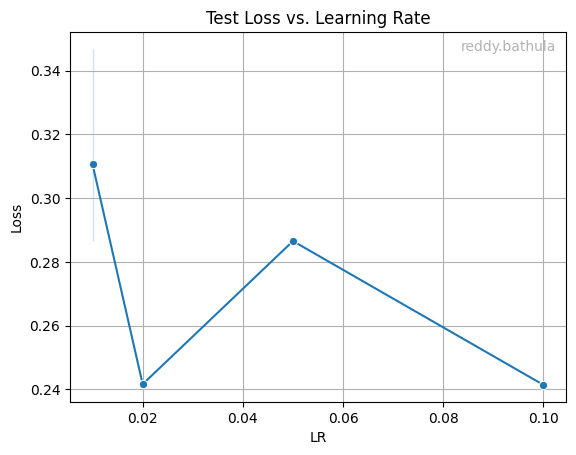

In [15]:
sns.lineplot(data=opt_results_df, x="LR", y="Loss", marker="o")
plt.title("Test Loss vs. Learning Rate")
plt.grid(True); _watermark(USERNAME, plt.gca())
plt.show()

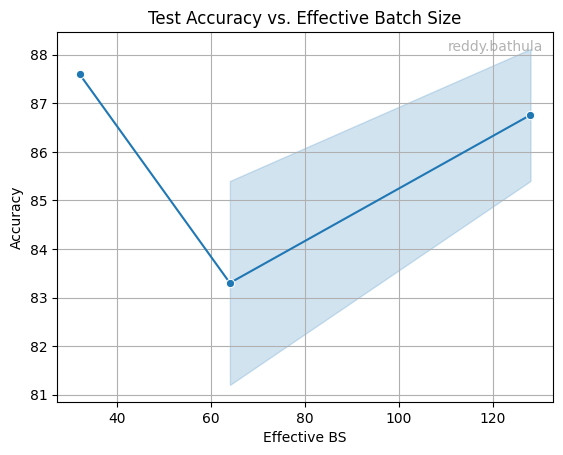

In [16]:
opt_results_df["Effective BS"] = opt_results_df["Batch Size"] * opt_results_df["Grad Accum"]
sns.lineplot(data=opt_results_df, x="Effective BS", y="Accuracy", marker="o")
plt.title("Test Accuracy vs. Effective Batch Size")
plt.grid(True); _watermark(USERNAME, plt.gca())
plt.show()

In [20]:
# Extract final parameters
final_params = {
    'depth': 6,
    'width': 32,
    'activation': ReLU(),
    'activation_name': 'ReLU',
    'epochs': 1000,
    'batch_size': 4,
    'learning_rate': 0.1,
    'patience': 1001,
    'relative_loss_threshold': 0.001,
    'lr_scheduler_step': 150,
    'lr_scheduler_gamma': 0.1,
}

# Define model
layers = [Linear(2, final_params['width'], final_params['activation'])]
for _ in range(final_params['depth'] - 1):
    layers.append(Linear(final_params['width'], final_params['width'], final_params['activation']))
layers.append(Linear(final_params['width'], 1, Sigmoid()))
model = Model(layers, loss_fn=BCE())

# Define run name and config
run_name = f"Final-MinModelSize-D{final_params['depth']}-W{final_params['width']}-{final_params['activation_name']}"
wandb_config = {
    "depth": final_params['depth'],
    "width": final_params['width'],
    "activation": final_params['activation_name'],
    "learning_rate": final_params['learning_rate'],
    "batch_size": final_params['batch_size'],
    "patience": final_params['patience'],
    "relative_loss_threshold": final_params['relative_loss_threshold'],
    "scheduler_step": final_params['lr_scheduler_step'],
    "scheduler_gamma": final_params['lr_scheduler_gamma']
}

# Run training
trained_model, history, run_folder = train_model(
    model=model,
    data=(X_train, y_train),
    run_name=run_name,
    username=USERNAME,
    epochs=final_params['epochs'],
    batch_size=final_params['batch_size'],
    learning_rate=final_params['learning_rate'],
    wandb_config=wandb_config,
    grad_accumulation_steps=1,
    patience=final_params['patience'],
    relative_loss_threshold=final_params['relative_loss_threshold'],
    RUNS_DIR="runs/final_challenge"
)

# Evaluate on test set
test_preds = trained_model.predict(X_test)
final_loss = BCE().forward(test_preds, y_test)
final_acc = np.mean((test_preds > 0.5).astype(int) == y_test) * 100

print(f"\n Final Test Accuracy: {final_acc:.2f}%")
print(f" Final Test Loss: {final_loss:.4f}")

# Save prediction map
plot_path = os.path.join(run_folder, f"{run_name}_map.png")
plot_map_results(trained_model, all_coords_norm, border_dataset.labels,
                 (border_dataset.height, border_dataset.width), USERNAME, plot_path)

Training 'Final-MinModelSize-D6-W32-ReLU': 100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s, loss=0.427911]



 Final Test Accuracy: 81.20%
 Final Test Loss: 0.4145


In [24]:
final_params = {
    'depth': 8,
    'width': 32,
    'activation': ReLU(),
    'activation_name': 'ReLU',
    'epochs': 200,
    'batch_size': 4,
    'learning_rate': 0.2,
    'patience': 50,
    'relative_loss_threshold': 0.005,
    'lr_scheduler_step': 15,
    'lr_scheduler_gamma': 0.1,
}

# Build model
layers = [Linear(2, final_params['width'], final_params['activation'])]
for _ in range(final_params['depth'] - 1):
    layers.append(Linear(final_params['width'], final_params['width'], final_params['activation']))
layers.append(Linear(final_params['width'], 1, Sigmoid()))
model = Model(layers, loss_fn=BCE())

# Define run name and config
run_name = f"Final-MinData-D{final_params['depth']}-W{final_params['width']}-{final_params['activation_name']}-{2048}samples"
wandb_config = {
    "depth": final_params['depth'],
    "width": final_params['width'],
    "activation": final_params['activation_name'],
    "learning_rate": final_params['learning_rate'],
    "batch_size": final_params['batch_size'],
    "patience": final_params['patience'],
    "relative_loss_threshold": final_params['relative_loss_threshold'],
    "scheduler_step": final_params['lr_scheduler_step'],
    "scheduler_gamma": final_params['lr_scheduler_gamma'],
    "samples_used": 2048
}

# Run training
trained_model, history, run_folder = train_model(
    model=model,
    data=(X_train, y_train),
    run_name=run_name,
    username=USERNAME,
    epochs=final_params['epochs'],
    batch_size=final_params['batch_size'],
    learning_rate=final_params['learning_rate'],
    wandb_config=wandb_config,
    grad_accumulation_steps=1,
    patience=final_params['patience'],
    relative_loss_threshold=final_params['relative_loss_threshold'],
    RUNS_DIR="runs/final_challenge"
)

# Evaluate
test_preds = trained_model.predict(X_test)
final_loss = BCE().forward(test_preds, y_test)
final_acc = np.mean((test_preds > 0.5).astype(int) == y_test) * 100

print(f"\n Final Test Accuracy: {final_acc:.2f}% using {2048} samples")
print(f" Final Test Loss: {final_loss:.4f}")

# Save prediction map
plot_path = os.path.join(run_folder, f"{run_name}_map.png")
plot_map_results(trained_model, all_coords_norm, border_dataset.labels,
                 (border_dataset.height, border_dataset.width), USERNAME, plot_path)

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7329b38ff0b0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7329c0a06430, raw_cell="final_params = {
    'depth': 8,
    'width': 32,
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/detour/Documents/SMAI/Assignments/assignment3/assignment-3-shailendrasekhar/BelgiumNetherlandsBorder.ipynb#X34sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

socket.send() raised exception.


BrokenPipeError: [Errno 32] Broken pipe

socket.send() raised exception.
socket.send() raised exception.


Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7329b38ff0b0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7329c0a04670, execution_count=24 error_before_exec=None error_in_exec=[Errno 32] Broken pipe info=<ExecutionInfo object at 7329c0a06430, raw_cell="final_params = {
    'depth': 8,
    'width': 32,
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/detour/Documents/SMAI/Assignments/assignment3/assignment-3-shailendrasekhar/BelgiumNetherlandsBorder.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe